# Bird Call Classifier

## Import Required Libraries

In [193]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


## Establish Bird Classes and Create a Label Map

In [194]:
# Initialize bird classes 
bird_classes = sorted(os.listdir("../data/raw/"))

# Initialize a label map for bird classes
label_map = {}

for idx in range(len(bird_classes)):
    bird = bird_classes[idx]
    label_map[bird] = idx

print("BIRD CLASSES:\n", bird_classes, "\n")
print("LABEL MAP:\n", label_map)

BIRD CLASSES:
 ['bald_eagle', 'northern_cardinal'] 

LABEL MAP:
 {'bald_eagle': 0, 'northern_cardinal': 1}


## Creating the Dataset and Dataloaders

In [195]:
# Initialize the data direcotry
data_directory = "../data/processed/"

# Initilize lists to hold all spectrograms and labels
all_spectrograms = []
all_labels = []
all_filenames = []

# Loop through each bird class directory and load the spectrograms
for bird in bird_classes:
    bird_directory = os.path.join(data_directory, bird)

    # Loop through each file in the bird directory
    for file_name in os.listdir(bird_directory):

        # Check if the file is a numpy file
        if file_name.endswith(".npy"):
            file_path = os.path.join(bird_directory, file_name)

            # Load the spectrogram
            spectrogram = np.load(file_path)

            # Convert the spectrogram to a tensor
            spectrogram_tensor = torch.tensor(spectrogram).unsqueeze(0).float()

            # Append the spectrogram tensor and label to their respective lists
            all_spectrograms.append(spectrogram_tensor)
            all_labels.append(label_map[bird])
            all_filenames.append(file_name)

# Stack all tensors into a single tensor
x = torch.stack(all_spectrograms)
y = torch.tensor(all_labels)

# Split the dataset into training, validation, and testing sets
x_train, x_temp, y_train, y_temp, file_name_train, file_name_temp = train_test_split(x, y, all_filenames, test_size = 0.2, stratify = y, random_state = 7)

x_val, x_test, y_val, y_test, file_name_val, file_name_test = train_test_split(x_temp, y_temp, file_name_temp, test_size = 0.5, stratify = y_temp, random_state = 7)

# Create the tensor datasets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

# Create the DataLoaders
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 16, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle = False)

In [196]:
# Sanity Check for dataset shapes
total_calls = len(all_spectrograms)

print("TRAINING:")
print("x shape:", x_train.shape)
print("y shape:", y_train.shape)
print(f"Percentage: {len(x_train) / total_calls * 100:.2f}\n")

print("VALIDATION:")
print("x shape:", x_val.shape)
print("y shape:", y_val.shape)
print(f"Percentage: {len(x_val) / total_calls * 100:.2f}\n")

print("TESTING:")
print("x shape:", x_test.shape)
print("y shape:", y_test.shape)
print(f"Percentage: {len(x_test) / total_calls * 100:.2f}\n")

TRAINING:
x shape: torch.Size([56, 1, 128, 216])
y shape: torch.Size([56])
Percentage: 78.87

VALIDATION:
x shape: torch.Size([7, 1, 128, 216])
y shape: torch.Size([7])
Percentage: 9.86

TESTING:
x shape: torch.Size([8, 1, 128, 216])
y shape: torch.Size([8])
Percentage: 11.27



## Neural Network Model

In [197]:
class BirdCallCNN(nn.Module):
    def __init__(self, num_classes):
        super(BirdCallCNN, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(1, 16, kernel_size = 3, padding = 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)  # Halves spatial dims

        # Second convolutional layer
        self.conv2 = nn.Conv2d(16, 32, kernel_size = 3, padding = 1)
        self.bn2 = nn.BatchNorm2d(32)

        # Third convolutional layer
        self.conv3 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
        self.bn3 = nn.BatchNorm2d(64)

        # Initialize flattened size based on input dimensions
        flattened_size = 64 * 16 * 27

        # Fully connected layers
        self.fc1 = nn.Linear(flattened_size, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        
        # Forward pass through the CNN
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        # Flatten the tensor fo the fully connected layers
        x = x.view(x.size(0), -1)

        # ReLU activation
        x = F.relu(self.fc1(x))

        # Output layer 
        x = self.fc2(x)

        # Softmax activation for multi-class classification
        return x


## Training Loop

In [198]:
# Function to train the model
def train_model(model, train_dataloader, val_dataloader, device, patience = 5, epochs = 10, print_epochs = False):
    # Establish the loss function
    criterion = nn.CrossEntropyLoss()

    # Establish the optimizer
    optimizer = optim.Adam(model.parameters(), lr = 0.001)

    model.to(device)

    # Lists to store values across epochs
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    # Early stopping criteria
    best_val_loss = float("inf")
    early_stopping_counter = 0

    # Loop through epochs
    for epoch in range(epochs):
        # ----- TRAINING LOOP -----

        # Set the model to training mode
        model.train()

        # initialize varibles to track loss and accuracy
        running_train_loss = 0.0
        train_correct = 0
        train_total = 0

        # Loop through dataloader
        for inputs, labels in train_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Update running loss and accuracy
            running_train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        # Calculate running training loss and accuracy
        train_loss = running_train_loss / train_total
        train_accuracy = train_correct / train_total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # ----- VALIDATION LOOP -----
        model.eval()
        running_val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(inputs)

                # Calculate validation loss
                loss = criterion(outputs, labels)

                # Updated running validation loss and accuracy
                running_val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = running_val_loss / val_total
        val_accuracy = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Print epoch statistics
        if print_epochs == True:
            print(f"Epoch {epoch + 1}:")
            print(f"\tTraining Loss: {train_loss:.4f} | Training Accuracy: {train_accuracy:.4f}")
            print(f"\tValidation Loss: {val_loss:.4f} | Training Accuracy: {val_accuracy:.4f}\n")

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs")
            break

    return train_losses, train_accuracies, val_losses, val_accuracies

In [199]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BirdCallCNN(num_classes = len(label_map))

train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, device, epochs = 50, print_epochs = False)

Early stopping triggered after 7 epochs


## Visualize Training and Validation Losses and Accuracies

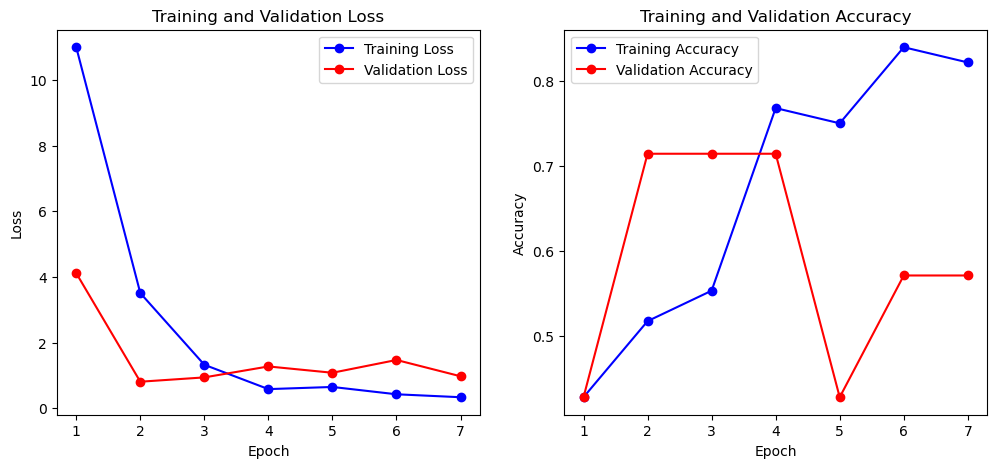

In [200]:
def plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize = (12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label = "Training Loss", marker = "o",color = "blue")
    plt.plot(epochs, val_losses, label = "Validation Loss", marker = "o",color = "red")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label = "Training Accuracy", marker = "o", color = "blue")
    plt.plot(epochs, val_accuracies, label = "Validation Accuracy", marker = "o",color = "red")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()

    plt.show()

plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies)

## Evaluate the Test Set

In [201]:
def evaluate(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

In [202]:
all_preds, all_labels = evaluate(model, test_loader, device)

In [203]:
predictions_df = pd.DataFrame({
    "Filename": file_name_test,
    "Actual": all_labels,
    "Predicted": all_preds    
})

predictions_df.head(10)

,Filename,Actual,Predicted
0,northern_cardinal_12.npy,1,0
1,northern_cardinal_30.npy,1,0
2,bald_eagle_30.npy,0,0
3,bald_eagle_12.npy,0,0
4,northern_cardinal_13.npy,1,1
5,northern_cardinal_18.npy,1,1
6,bald_eagle_32.npy,0,0
7,bald_eagle_13.npy,0,0


## Classification Report and Confusion Matrix

                   precision    recall  f1-score   support

       bald_eagle       0.67      1.00      0.80         4
northern_cardinal       1.00      0.50      0.67         4

         accuracy                           0.75         8
        macro avg       0.83      0.75      0.73         8
     weighted avg       0.83      0.75      0.73         8



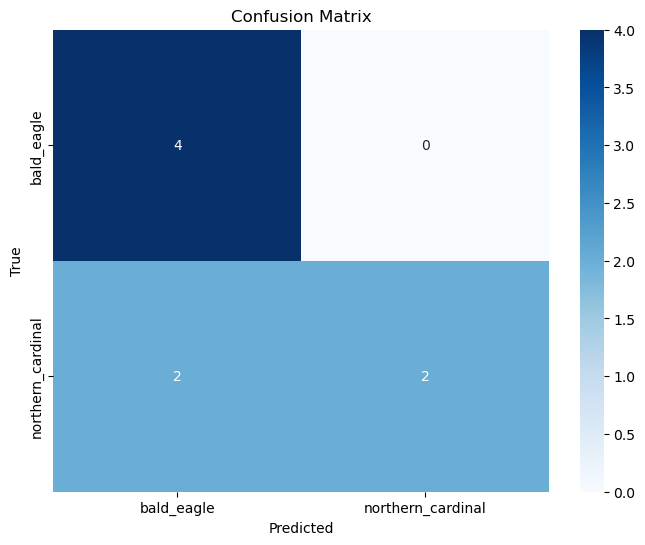

In [204]:
# Print classification report
target_names = list(label_map.keys())
print(classification_report(all_labels, all_preds, target_names = target_names))

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize = (8, 6))
sns.heatmap(cm, annot = True, fmt = "d", xticklabels = target_names, yticklabels = target_names, cmap = "Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()